# What’s in a Song Title? Exploring Sentiment, Language, and Audio in Popular Music

How do the sentiment and language of song titles relate to a song’s popularity?

Can we group songs by emotion and sound using clustering?

Can we predict a song’s popularity using machine learning models based on title features and audio characteristics?

link to data set: [spotify top hits](https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019)

# Section 1: Data Preprocessing & Feature Engineering

### Import Libraries

In [386]:
import pandas as pd 
import matplotlib.pyplot as plt
import re
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
import numpy as np
from sklearn.cluster import KMeans
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

### Class SpotifyData

In [502]:
stop_words = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
'ourselves', 'you', "youre", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 
'yourselves', 'he', 'him', 'his', 'himself', 'she', "shes", 'her', 'hers', 'herself', 
'it', "its", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
 'what', 'which', 'who', 'whom', 'this', 'that', "thatll", 'these', 'those', 'am', 'is', 'are',
 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 
'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 
'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 
'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 
'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 
's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y',
 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 
'hadn', "hadnt", 'hasn', "hasnt", 'haven', "havent", 'isn', "isnt", 'ma', 'mightn',
 "mightnt", 'mustn', "mustnt", 'needn', "neednt", 'shan', "shant", 'shouldn', "shouldnt", 
'wasn', "wasnt", 'weren', "werent", 'won', "wont", 'wouldn', "wouldnt","feat", "radio edit", "remix", "dont", "u","im","uh","wit","cant", "version"])
# added words like 'feat,' 'radio edit,' and "remix" after seeing word clouds

class SpotifyData:
    """
    A class to hold Spotify API data. Provides methods to filter, analyze, and visualize the data.
    """
    
    def __init__(self, file_path):
        """
        Initializes the ModerationData class.

        Args:
            file_path (str): Path to the dataset file (CSV).
        """
        self.file_path = file_path  
        self.df = pd.read_csv(file_path)
        print("Data Succesfully Loaded!")
        
    def clean_data(self):
        """
        Clean 'song' and 'artist' columns and handle 'genre' inconsistencies:
        - Convert text to lowercase
        - Remove punctuation, numbers, and extra whitespace
        - Remove common stopwords
        - Replace invalid genre values like 'set()' with NaN
        - Drop rows with missing genre
        - Simplify genre to first entry (e.g., keep 'pop' from 'pop, dance-pop')
        """
        
        def clean_text(text):
            text = str(text).lower()
            text = re.sub(r'[^\w\s]', '', text)        # Remove punctuation
            text = re.sub(r'\d+', '', text)            # Remove numbers
            text = re.sub(r'\s+', ' ', text).strip()   # Remove extra spaces

            # Remove common stopwords
            pattern = r'\b(' + '|'.join(map(re.escape, stop_words)) + r')\b'
            text = re.sub(pattern, '', text)

            return text

        # Apply cleaning to 'song' and 'artist' columns
        for col in ['song', 'artist']:
            if col in self.df.columns:
                self.df[col] = self.df[col].apply(clean_text)

        # Count and display rows with invalid 'genre' value "set()"
        invalid_genre = self.df['genre'].astype(str).str.strip() == "set()"
        print(f"Number of rows with genre 'set()' before cleaning: {invalid_genre.sum()}")

        # Replace 'set()' with NaN for better handling
        self.df['genre'] = self.df['genre'].replace(r'^\s*set\(\)\s*$', np.nan, regex=True)

        # Drop rows with missing genres
        self.df = self.df[self.df['genre'].notna()]

        # Keep only the first listed genre in multi-genre entries
        self.df['genre'] = self.df['genre'].astype(str).str.split(',').str[0].str.strip()

        print("'song' and 'artist' columns successfully cleaned.")
        print("Invalid 'genre' values replaced and simplified.")



    def song_feature_distribution(self):
        """
        Plot histograms of key song-level features to show their distributions.
        Features include: popularity, danceability, energy, loudness, speechiness,
        acousticness, tempo, liveness, and valence.
        Saves the figure as 'Distribution_of_Song_Features.png'.
        """

        # List of audio and popularity-related features to visualize
        features = [
            "popularity", "danceability", "energy", 
            "loudness", "speechiness", "acousticness", 
            "tempo", "liveness", "valence"
        ]

        # Assigned colors for each histogram for visual clarity
        colors = [
            "b", "g", "r",         # blue, green, red
            "c", "m", "y",         # cyan, magenta, yellow
            "k", "lightcoral", None  # black, coral, and default for last plot
        ]

        # Create a 3x3 grid of subplots
        fig, axs = plt.subplots(3, 3, figsize=(15, 15))
        fig.suptitle("Distribution of Song Features", fontsize=16)

        # Loop through each feature and plot a histogram in the appropriate subplot
        for i, feature in enumerate(features):
            row, col = divmod(i, 3)  # Determine subplot position
            axs[row, col].hist(self.df[feature], bins=30, color=colors[i])  # Plot histogram
            axs[row, col].set_title(feature)  # Set subplot title to feature name

        # Adjust layout to prevent overlap and save the figure
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.savefig("Distribution_of_Song_Features.png")
        plt.show()

    def feature_heatmap(self):
        """
        Creates a heatmap to visualize correlations between numerical song features.

        - Drops non-numeric columns ('artist', 'song', 'genre') to focus on numerical data
        - Computes Pearson correlation between all numeric features
        - Uses seaborn to plot a color-coded heatmap with annotation
            - Positive values indicate direct relationships (e.g., energy ↔ loudness)
              - Negative values indicate inverse relationships (e.g., acousticness ↔ loudness)
        - Saves the figure as 'Correlation Heatmap.png'
    
        Returns:
            corr (DataFrame): The computed correlation matrix
        """

        # Remove text-based and categorical columns to isolate numerical features
        filtered_df = self.df.drop(columns=['artist', 'song', 'genre'])

        # Calculate correlation matrix between numeric features
        corr = filtered_df.corr()

        # Create the heatmap figure
        fig, ax = plt.subplots(figsize=(15, 15))
        sns.heatmap(corr, annot=True)  # Display correlation values in each cell
        ax.set_title('Song Feature Correlation Heatmap')

        # Save and display the heatmap
        plt.savefig("Correlation Heatmap.png")
        plt.show()

        return corr  # Return the correlation matrix 

    def plot_popularity_scatterplots(self):
        """
        Creates a 2x3 grid of scatterplots showing relationships between popularity and 
        various song features like danceability, loudness, valence, etc.
        Adds a linear trend line to each plot to show general direction of the relationship.
        Saves the figure as 'Popularity_Against_Features.png'.
        """

        # List of audio features to compare against popularity, each paired with a unique color
        features = [
            ("danceability", "skyblue"),
            ("loudness", "forestgreen"),
            ("speechiness", "slateblue"),
            ("duration_ms", "goldenrod"),
            ("valence", "lightcoral"),
            ("energy", "blueviolet")
        ]

        # Create a 2x3 grid of subplots
        fig, axs = plt.subplots(2, 3, figsize=(12, 10))
        fig.suptitle("Song Features vs. Popularity", fontsize=16)

        for i, (feature, color) in enumerate(features):
            row, col = divmod(i, 3)
            x = self.df[feature]
            y = self.df["popularity"]

            # Plot the scatterplot of feature vs popularity
            axs[row, col].scatter(x, y, c=color, alpha=0.7)

            # Calculate and plot a linear regression trend line
            slope, intercept = np.polyfit(x, y, 1)  # Fit a 1st-degree polynomial (line)
            axs[row, col].plot(x, slope * x + intercept, color='black', linestyle='--', linewidth=2)

            # Label axes and title
            axs[row, col].set_xlabel(feature.replace("_", " ").title())
            axs[row, col].set_ylabel("Popularity")
            axs[row, col].set_title(f"{feature.replace('_', ' ').title()} vs. Popularity")

        # Adjust layout and save the full figure
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig("Popularity_Against_Features.png")
        plt.show()

    def popularity_by_genre(self):
        """
        Plots a horizontal bar chart showing song popularity by genre.
        - If multiple genres are listed, only the first one is used.
        - Saves the plot as 'Popularity by Genre.png'.
        """

        # Clean the genre column to take only the first genre if multiple are listed
        self.df['genre'] = self.df['genre'].astype(str).str.split(',').str[0].str.strip()

        # Sort songs by popularity
        df_sorted = self.df.sort_values('popularity', ascending=False)

        # Plot horizontal bar chart
        plt.figure(figsize=(10, 12))
        plt.barh(df_sorted['genre'], df_sorted['popularity'], color='plum')
        plt.xlabel('Popularity')
        plt.ylabel('Genre')
        plt.title('Popularity by Genre')
        plt.tight_layout()
        plt.savefig("Popularity by Genre.png")
        plt.show()

    def explicit_pie_chart(self):
        """
        Creates a pie chart showing the proportion of explicit vs. non-explicit songs.
        Saves the figure as 'Explicit Song Piechart.png'.
        """

        # Use value_counts to get the count of True (explicit) and False (non-explicit)
        # .get(True, 0) ensures it returns 0 if True isn't present in the column
        explicit_count = self.df["explicit"].value_counts().get(True, 0)
        not_explicit_count = self.df["explicit"].value_counts().get(False, 0)

        # Create a pie chart to visualize the distribution between explicit and non-explicit songs
        plt.figure(figsize=(6, 6))  # Set figure size for a balanced circular layout

        # Plot pie chart with labeled slices and percentage formatting
        plt.pie(
            [explicit_count, not_explicit_count],  # Values for each slice
            labels=["Explicit", "Not Explicit"],   # Labels for the legend
            autopct="%1.1f%%",                     # Show percentages with 1 decimal
            colors=["tomato", "lightgreen"]        # Assign distinct colors to each category
        )

        # Add a title and save the figure as a PNG
        plt.title("Explicit vs Not Explicit Songs")
        plt.savefig("Explicit Song Piechart.png")
        plt.show()  # Display the plot


    def explicit_popularity(self):
        """
        Plots a boxplot comparing the popularity distribution of explicit vs. non-explicit songs.
        Helps visually assess whether one group tends to be more popular.
        Saves the figure as 'Popularity by Explicity.png'.
        """

        # Clean the dataset by removing any rows with missing values in 'explicit' or 'popularity'
        # This ensures we only plot valid, complete data
        df_clean = self.df.dropna(subset=["explicit", "popularity"])

        # Create a new figure with defined size for the boxplot
        plt.figure(figsize=(8, 6))

        # Plot a boxplot using seaborn to compare popularity scores across explicit vs. non-explicit songs
        # 'hue' adds color differentiation between the two categories
        sns.boxplot(
            data=df_clean,
            x="explicit", 
            y="popularity", 
            hue="explicit", 
            palette="pastel"
        )

        # Replace 0/1 on x-axis with readable labels
        plt.xticks([0, 1], ["Not Explicit", "Explicit"])

        # Add title and axis labels for clarity
        plt.title("Popularity Distribution: Explicit vs Non-Explicit Songs", fontsize=14)
        plt.xlabel("")  # No x-label since categories are self-explanatory
        plt.ylabel("Popularity", fontsize=12)

        # Add horizontal gridlines for easier comparison
        plt.grid(axis='y', linestyle='--', alpha=0.6)

        # Optimize layout and save the plot to file
        plt.tight_layout()
        plt.savefig("Popularity by Explicity.png")
        plt.show()


    def wordcloud_from_titles(self):
        """
        Generates and displays a word cloud from all track titles in the dataset.
        Helps visualize the most frequently used words across song names.
        Saves the figure as 'Song WordCloud.png'.
        """

        # Combine all non-null song titles into a single string for text analysis
        # Using .astype(str) ensures compatibility in case of any non-string values
        all_titles = " ".join(self.df["song"].dropna().astype(str))

        # Create a word cloud object from the combined titles
        # The more frequently a word appears, the larger it appears in the cloud
        wordcloud = WordCloud(
            width=800, 
            height=400, 
            background_color='white'
        ).generate(all_titles)

        # Display the generated word cloud using matplotlib
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation="bilinear")  # Smooth rendering
        plt.axis("off")  # Hide axis for a cleaner look
        plt.title("Most Common Words in Track Titles", fontsize=14)
        plt.tight_layout()

        # Save and show the word cloud image
        plt.savefig("Song WordCloud.png")
        plt.show()


    def wordclouds_by_genre(self):
        """
        Creates a grid of word clouds showing the most common words in track titles,
        grouped by genre. Useful for visualizing genre-specific language patterns.
        Saves the figure as 'Song Genres Word Clouds.png'.
        """

        # Get unique, non-null genre values
        genres = self.df["genre"].dropna().unique()
        num_genres = len(genres)

        # Set layout with 3 columns and enough rows to fit all genres
        cols = 3
        rows = math.ceil(num_genres / cols)

        # Create a grid of subplots sized according to the number of genres
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
        axes = axes.flatten()  # Flatten the 2D array for easier indexing in a loop

        # Generate a word cloud for each genre
        for idx, genre in enumerate(genres):
            # Filter songs that belong to the current genre
            genre_songs = self.df[self.df["genre"] == genre]

            # Combine all song titles into a single string
            all_titles = " ".join(genre_songs["song"].astype(str))
    
            # Skip if there are no titles to generate a cloud from
            if not all_titles.strip():
                continue

            # Create a word cloud from the titles
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_titles)

            # Display the word cloud in the subplot
            axes[idx].imshow(wordcloud, interpolation="bilinear")
            axes[idx].axis("off")  # Hide axis for a clean look
            axes[idx].set_title(f"{genre.title()}", fontsize=12)  # Set genre title

        # Hide any extra/unused subplot axes
        for j in range(idx + 1, len(axes)):
            axes[j].axis("off")

        # Format and save the entire figure
        plt.tight_layout()
        plt.savefig("Song Genres Word Clouds.png")
        plt.show()


    def sentiment_analysis_by_genre(self):
        """
        Computes sentiment polarity and subjectivity of song titles using TextBlob,
        then visualizes sentiment patterns across all songs and grouped by genre.
        Saves the genre-by-genre sentiment chart as 'Sentiment by Genre.png'.
        """

        def compute_sentiment(text):
            """
            Helper function to compute sentiment polarity and subjectivity using TextBlob.
            - Polarity: [-1, 1], where -1 is negative and 1 is positive
            - Subjectivity: [0, 1], where 0 is objective and 1 is subjective
            """
            blob = TextBlob(str(text))
            return blob.sentiment.polarity, blob.sentiment.subjectivity

        # Apply sentiment analysis to all song titles
        # Drops nulls, applies sentiment function, and stores polarity + subjectivity in new columns
        self.df[['polarity', 'subjectivity']] = self.df['song'].dropna().apply(
            lambda t: pd.Series(compute_sentiment(t))
        )

        # Global sentiment scatterplot for all songs, colored by genre
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            x="polarity", y="subjectivity",
            hue="genre", data=self.df,
            palette="deep", alpha=0.6
        )
        plt.title("Song Title Sentiment by Genre")
        plt.xlabel("Sentiment Polarity")
        plt.ylabel("Sentiment Subjectivity")
        plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Genre-specific sentiment scatterplots
        genres = self.df['genre'].dropna().unique()
        num_genres = len(genres)
        cols = 3  # Define number of columns in subplot grid
        rows = math.ceil(num_genres / cols)  # Calculate number of rows needed

        # Create subplot grid for genre-specific scatterplots
        fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
        axes = axes.flatten()  # Flatten in case of multi-dimensional array

        for i, genre in enumerate(genres):
            ax = axes[i]
            subset = self.df[self.df['genre'] == genre]  # Filter songs by genre
            ax.scatter(subset['polarity'], subset['subjectivity'], alpha=0.6)
            ax.set_title(genre)
            ax.set_xlim(-1.05, 1.05)  # Standard polarity range
            ax.set_ylim(-0.05, 1.05)  # Standard subjectivity range
            ax.set_xlabel("Polarity")
            ax.set_ylabel("Subjectivity")
            ax.grid(True)

        # Hide any unused subplot axes
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        # Add a global title and save the final figure
        plt.suptitle("Sentiment Scatter Plots by Genre", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.savefig("Sentiment by Genre.png")
        plt.show()


    def plot_sentiment_distribution(self):
        """
        Computes sentiment polarity for each song title and categorizes it as
        Positive, Neutral, or Negative. Then plots a bar chart showing the distribution.
        Saves the figure as 'Sentiment Distribution.png'.
        """

        # Calculate sentiment polarity for each song title using TextBlob
        # Polarity ranges from -1 (very negative) to 1 (very positive)
        self.df['sentiment'] = self.df['song'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

        # Define a function to classify sentiment into categories
        def categorize_sentiment(score):
            if score > 0.1:
                return 'Positive'
            elif score < -0.1:
                return 'Negative'
            else:
                return 'Neutral'

        # Apply sentiment categorization to each song based on its polarity score
        self.df['sentiment_category'] = self.df['sentiment'].apply(categorize_sentiment)

        # Plot a bar chart showing the count of songs in each sentiment category
        self.df['sentiment_category'].value_counts().plot(
            kind='bar',  # Bar chart format
            color=['lightgray', 'lightgreen', 'salmon'],  # Custom colors for each sentiment
            edgecolor='black'  # Adds a border around bars for clarity
        )

        # Add chart title and axis labels
        plt.title('Sentiment Distribution of Song Titles')
        plt.xlabel('Sentiment')
        plt.ylabel('Number of Songs')
        plt.xticks(rotation=0)  # Keep x-axis labels horizontal for readability
        plt.tight_layout()

        # Save and display the final plot
        plt.savefig("Sentiment Distribution.png")
        plt.show()


    def extract_features(self):
        """
        Extracts sentiment, textual, and engineered audio/contextual features from the dataset.
        Also prepares data for machine learning by defining predictors (X) and targets for
        both regression and classification.
        """

        # TEXT & SENTIMENT FEATURES FROM SONG TITLES 

        # Polarity score: ranges from -1 (negative) to +1 (positive)
        self.df["title_sentiment"] = self.df["song"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

        # Subjectivity score: ranges from 0 (objective) to 1 (subjective/opinion-based)
        self.df["title_subjectivity"] = self.df["song"].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

        # Title length in characters
        self.df["title_length"] = self.df["song"].apply(lambda x: len(str(x)))

        # Title word count
        self.df["word_count"] = self.df["song"].apply(lambda x: len(str(x).split()))

        # ARTIST & GENRE CONTEXTUAL FEATURES 

        # Number of songs by the same artist (artist popularity proxy)
        self.df["artist_song_count"] = self.df["artist"].map(self.df["artist"].value_counts())

        # Average popularity of songs in the same genre (genre-based context)
        self.df["genre_popularity_mean"] = self.df.groupby("genre")["popularity"].transform("mean")

        # ENGINEERED AUDIO FEATURES 

        # Binary indicator: is the song high energy?
        self.df["is_high_energy"] = (self.df["energy"] > 0.8).astype(int)

        # Binary indicator: is the song danceable?
        self.df["is_danceable"] = (self.df["danceability"] > 0.7).astype(int)

        # Categorize tempo into buckets (slow, medium, fast)
        self.df["tempo_bucket"] = pd.cut(
            self.df["tempo"],
            bins=[0, 90, 120, 200],
            labels=["slow", "medium", "fast"]
        )

        # Interaction term: energy × danceability
        self.df["energy_danceability_combo"] = self.df["energy"] * self.df["danceability"]

        # TEMPORAL FEATURES 

        # Indicator for whether the song is from 2019 or later
        self.df["recent_release"] = (self.df["year"] >= 2019).astype(int)

        # Decade the song was released in (e.g., 2010s)
        self.df["decade"] = (self.df["year"] // 10) * 10

        # FINAL FEATURE SET 

        features = [
            "title_sentiment", "title_subjectivity", "title_length", "word_count",
            "valence", "energy", "danceability", "acousticness", "speechiness",
            "artist_song_count", "genre_popularity_mean",
             "is_high_energy", "is_danceable", "energy_danceability_combo",
            "recent_release"
        ]

        # Drop any rows that have missing values in selected feature columns
        self.X = self.df[features].dropna()

        # TARGET VARIABLES

        # Binary classification target: 1 if popularity > 70, else 0
        self.df["popular"] = (self.df["popularity"] > 70).astype(int)

        # Set up target variables for classification and regression
        self.y_class = self.df.loc[self.X.index, "popular"]      # For classification tasks
        self.y_reg = self.df.loc[self.X.index, "popularity"]     # For regression tasks

        print("Features and targets successfully extracted.")


    def cluster_songs(self, n_clusters=3):
        """
        Standardizes features and applies K-Means clustering to group songs based on
        sentiment and audio features. Uses PCA for 2D visualization, labels cluster centroids,
        and displays keywords that define each cluster.
        Saves the figure as 'Song Clusters.png'.

        Args:
            n_clusters (int): Number of clusters to form (default = 3).
        """

        # Ensure features have been extracted
        if not hasattr(self, 'X'):
            raise AttributeError("You must run extract_features() before clustering.")

        # Standardize Features 
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X)

        # K-Means Clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(X_scaled)
        self.df.loc[self.X.index, "cluster"] = cluster_labels

        # PCA for 2D Visualization 
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        centroids_pca = pca.transform(kmeans.cluster_centers_)  # Project centroids into PCA space

        # Plot Clusters
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(
            X_pca[:, 0], X_pca[:, 1],
            c=cluster_labels, cmap="viridis", alpha=0.6,
            label=cluster_labels
        )

        # Plot centroids
        plt.scatter(
            centroids_pca[:, 0], centroids_pca[:, 1],
            marker='X', s=200, c='black', label='Centroids'
        )

        # Label each centroid with its cluster number
        for i, (x, y) in enumerate(centroids_pca):
            plt.text(x, y, f'Cluster {i}', fontsize=10, ha='center', va='center', color='white', weight='bold')

        plt.title("Song Clusters Based on Sentiment + Audio Features")
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.legend()
        plt.tight_layout()
        plt.savefig("Song Clusters.png")
        plt.show()

        # Print Keywords (Top Features) for Each Cluster 
        cluster_means = self.X.copy()
        cluster_means['cluster'] = cluster_labels
        feature_means = cluster_means.groupby('cluster').mean()

        print("\nTop Features per Cluster:")
        for cluster in range(n_clusters):
            print(f"\nCluster {cluster}:")
            top_features = feature_means.loc[cluster].sort_values(ascending=False).head(5)
            for feature, val in top_features.items():
                print(f"  {feature}: {val:.2f}")

    def plot_cluster_popularity(self):
        """
        Plots a boxplot showing the distribution of song popularity across clusters
        generated by K-Means. This helps assess whether certain clusters contain
         more or less popular songs on average.
        Saves the plot as 'Popularity Distribution per Cluster.png'.
        """

        # VALIDATION 
        # Before plotting, confirm that clustering has been done
        # The 'cluster' column should have been added by cluster_songs()
        if "cluster" not in self.df.columns:
            raise ValueError("Clusters not found. Please run cluster_songs() first.")

        # PLOT SETUP 
        # Create a new figure with defined size for clarity
        plt.figure(figsize=(8, 5))

        # BOXPLOT 
        # Plot popularity values grouped by cluster number
        # This reveals whether certain clusters have consistently higher or lower popularity scores
        sns.boxplot(
            x=self.df.loc[self.X.index, "cluster"],     # X-axis: cluster label
            y=self.df.loc[self.X.index, "popularity"]   # Y-axis: popularity values
        )

        # ANNOTATION 
        # Add a title and axis labels for readability
        plt.title("Popularity Distribution per Cluster")
        plt.xlabel("Cluster")      # Label clusters (0, 1, 2, etc.)
        plt.ylabel("Popularity")   # Label indicating what’s being measured

        # SAVE & DISPLAY 
        # Clean up layout and export the plot
        plt.tight_layout()
        plt.savefig("Popularity Distribution per Cluster.png")
        plt.show()


    def run_linear_regression(self):
        """
        Performs linear regression using the extracted and scaled features to predict song popularity.
        Prints the R² score, MSE, and feature coefficients.
        """

        # Ensure that feature extraction has been completed before proceeding
        # 'self.X' contains the predictor variables and 'self.y_reg' contains the regression target (popularity scores)
        # These are created inside extract_features(), so this check prevents downstream errors if the method wasn't run
        if not hasattr(self, "X") or not hasattr(self, "y_reg"):
            raise AttributeError("You must run extract_features() before this method.")

        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X)

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, self.y_reg, test_size=0.2, random_state=42
        )

        # Train linear regression model
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)

        # Print performance metrics
        print("Linear Regression Results")
        print("----------------------------")
        print("R² Score:", r2_score(y_test, y_pred))
        print("MSE:", mean_squared_error(y_test, y_pred))
        print("\nFeature Coefficients:")

        # Print coefficients with feature names
        for feature, coef in zip(self.X.columns, lr.coef_):
            print(f"{feature}: {coef:.4f}")

    def plot_regression_coefficients(self):
        """
        Plots the coefficients from a linear regression model to visualize how each feature
        influences song popularity. Positive coefficients indicate that increasing the feature
        increases predicted popularity, while negative coefficients indicate the opposite.
        Saves the plot as 'Linear Regression.png'.
        """

        # SAFETY CHECK 
        # Ensure feature and target variables are available
        # self.X = predictors, self.y_reg = target values (popularity)
        if not hasattr(self, "X") or not hasattr(self, "y_reg"):
            raise AttributeError("You must run extract_features() before plotting coefficients.")

        # DATA PREPARATION 
        # Standardize features to ensure all features are on the same scale
        # This prevents larger-valued features from dominating the model
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X)

        # Split data into training and testing sets (though only training is used here)
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, self.y_reg, test_size=0.2, random_state=42
        )
    
        # LINEAR REGRESSION MODEL 
        # Train a simple linear regression model to access the learned coefficients
        lr = LinearRegression()
        lr.fit(X_train, y_train)

        # Get the list of coefficients (weights assigned to each feature)
        coefficients = lr.coef_

        # PLOTTING 
        # Visualize the coefficients as a horizontal bar chart
        # Each bar shows the strength and direction of a feature's influence on popularity
        plt.figure(figsize=(8, 5))
        plt.barh(self.X.columns, coefficients)  # Horizontal bars for better label visibility
        plt.title("Feature Influence on Popularity (Linear Regression)")
        plt.xlabel("Coefficient Value")

        # Add a vertical line at 0 to show the neutral (no influence) baseline
        plt.axvline(0, color='gray', linestyle='--')

        # Optimize layout and save the figure
        plt.tight_layout()
        plt.savefig("Linear Regression.png")
        plt.show()


    def run_knn_classification(self, n_neighbors=5):
        """
        Performs k-Nearest Neighbors classification to predict whether a song is popular
        based on extracted features. Outputs a confusion matrix and classification report.

        Args:
            n_neighbors (int): Number of neighbors to consider in kNN. Default is 5.
        """

        # VALIDATION 
        # Ensure that the features (X) and classification target (y_class) exist
        # These are created in extract_features()
        if not hasattr(self, "X") or not hasattr(self, "y_class"):
            raise AttributeError("You must run extract_features() before classification.")

        # FEATURE SCALING 
        # Standardize the input features so that each one contributes equally
        # This is essential for kNN, which uses distance metrics that are sensitive to scale
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X)

        # SPLIT DATA 
        # Divide the data into training and testing subsets (80% train, 20% test)
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, self.y_class, test_size=0.2, random_state=42
        )
    
        # TRAIN kNN MODEL 
        # Create and train a k-Nearest Neighbors classifier using the specified number of neighbors
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_train, y_train)

        # Predict class labels for the test set
        y_pred = knn.predict(X_test)

        # EVALUATE PERFORMANCE 
        # Print model evaluation results including:
        # - Confusion matrix: actual vs predicted class breakdown
        # - Classification report: precision, recall, f1-score, support for each class
        print("k-Nearest Neighbors Classification")
        print("-------------------------------------")
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

    def plot_knn_confusion_matrix(self, n_neighbors=5):
        """
        Trains a kNN classifier and plots a labeled confusion matrix for prediction results.
        Helps visually assess how well the model distinguishes between popular and non-popular songs.
        Saves the matrix as 'Confusion Matrix.png'.

        Args:
            n_neighbors (int): Number of neighbors to use in kNN. Default is 5.
        """

        # VALIDATION 
        # Confirm that required features and labels are available before training the model
        if not hasattr(self, "X") or not hasattr(self, "y_class"):
            raise AttributeError("You must run extract_features() before classification.")

        # FEATURE SCALING 
        # Standardize feature values to ensure fair distance comparisons
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X)

        # SPLIT DATA 
        # Use 80/20 train-test split to evaluate generalization performance
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, self.y_class, test_size=0.2, random_state=42
        )

        # TRAIN kNN MODEL 
        # Fit a k-Nearest Neighbors classifier using the training data
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_train, y_train)

        # PLOT CONFUSION MATRIX 
        # Use sklearn's ConfusionMatrixDisplay to visualize prediction results
        ConfusionMatrixDisplay.from_estimator(
            knn, X_test, y_test,  # Model and data
            display_labels=["Not Popular", "Popular"],  # Human-readable class labels
            cmap="Blues"  # Color scheme for clarity
        )

        # Add title and save the plot to file
        plt.title(f"kNN Confusion Matrix (k={n_neighbors})")
        plt.tight_layout()
        plt.savefig("Confusion Matrix.png")
        plt.show()

    def tune_knn_neighbors(self, k_range=range(1, 21)):
        """
        Tests different values of k (number of neighbors) for k-Nearest Neighbors (kNN)
        classification to identify the best-performing setting.
        Prints accuracy scores and plots model performance across k values.

        Args:
            k_range (range): Range of k values to evaluate. Default is 1 to 20.
        """

        # SAFETY CHECK 
        # Ensure features (X) and classification targets (y_class) exist
        # These are generated during feature engineering via extract_features()
        if not hasattr(self, "X") or not hasattr(self, "y_class"):
            raise AttributeError("Run extract_features() first.")

        # DATA STANDARDIZATION 
        # Standardize features so all variables contribute equally to distance metrics
        # This is critical for distance-based models like kNN
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X)

        # TRAIN/TEST SPLIT 
        # Split the standardized data into training and test sets (80/20 split)
        # Used for fair evaluation of each k value
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, self.y_class, test_size=0.2, random_state=42
        )

        # HYPERPARAMETER TESTING 
        accuracies = []  # Store accuracy scores for each k

        print("Accuracy by k-value:")
        for k in k_range:
            # Initialize a kNN classifier with the current k
            knn = KNeighborsClassifier(n_neighbors=k)

            # Train the classifier on the training data
            knn.fit(X_train, y_train)

            # Predict on the test set and evaluate accuracy
            y_pred = knn.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            accuracies.append(acc)

            # Print the result for this k
            print(f"k = {k}: accuracy = {acc:.4f}")

        # VISUALIZE PERFORMANCE 
        # Plot accuracy scores across all tested k values
        plt.figure(figsize=(8, 5))
        plt.plot(list(k_range), accuracies, marker='o', color='navy')
        plt.title("kNN Accuracy vs. Number of Neighbors")
        plt.xlabel("Number of Neighbors (k)")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.xticks(list(k_range))  # Show all k values on the x-axis for clarity
        plt.tight_layout()
        plt.savefig("kNN_Accuracy_vs_k.png")
        plt.show()

        
    def run_random_forest_classification(self, n_estimators=100, max_depth=None):
        """
        Trains and evaluates a Random Forest classifier to predict whether a song is popular
        based on engineered features. Also visualizes feature importance scores.
    
        Args:
            n_estimators (int): Number of trees in the forest (default = 100).
            max_depth (int or None): Maximum depth of each tree. If None, nodes are expanded until pure.
        """

        # SAFETY CHECK 
        # Confirm that features (X) and target labels (y_class) are available
        if not hasattr(self, "X") or not hasattr(self, "y_class"):
            raise AttributeError("You must run extract_features() before classification.")

        # STANDARDIZE FEATURES 
        # Although Random Forests are not sensitive to feature scaling,
        # we scale here to stay consistent with other models and splits
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X)

        # TRAIN/TEST SPLIT 
        # Use 80% of data for training and 20% for testing
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, self.y_class, test_size=0.2, random_state=42
        )

        # MODEL TRAINING 
        # Create a Random Forest classifier with specified number of trees and max depth
        # This ensemble model builds multiple decision trees and aggregates their results
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42
        )

        # Fit the model to the training data
        rf.fit(X_train, y_train)

        # Predict class labels on the test set
        y_pred = rf.predict(X_test)

        # MODEL EVALUATION 
        # Output evaluation metrics:
        # - Confusion Matrix: actual vs. predicted counts
        # - Classification Report: precision, recall, F1-score, and support
        print("Random Forest Classification")
        print("------------------------------------------")
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # FEATURE IMPORTANCE 
        # Extract and plot feature importance scores
        # These scores indicate how useful each feature was across all decision trees
        importances = rf.feature_importances_

        plt.figure(figsize=(8, 5))
        sns.barplot(x=importances, y=self.X.columns)
        plt.title("Feature Importance (Random Forest)")
        plt.xlabel("Importance Score")
        plt.tight_layout()
        plt.savefig("RandomForest_Feature_Importance.png")
        plt.show()

## Part 1: Preprocessing

### Load Data

In [565]:
spotify = SpotifyData("songs_normalize.csv")

Data Succesfully Loaded!


In [567]:
spotify.df.head()

artist                    song  duration_ms  explicit  year  \
0  Britney Spears  Oops!...I Did It Again       211160     False  2000   
1       blink-182    All The Small Things       167066     False  1999   
2      Faith Hill                 Breathe       250546     False  1999   
3        Bon Jovi            It's My Life       224493     False  2000   
4          *NSYNC             Bye Bye Bye       200560     False  2000   

   popularity  danceability  energy  key  loudness  mode  speechiness  \
0          77         0.751   0.834    1    -5.444     0       0.0437   
1          79         0.434   0.897    0    -4.918     1       0.0488   
2          66         0.529   0.496    7    -9.007     1       0.0290   
3          78         0.551   0.913    0    -4.063     0       0.0466   
4          65         0.614   0.928    8    -4.806     0       0.0516   

   acousticness  instrumentalness  liveness  valence    tempo         genre  
0        0.3000          0.000018    0.3550    0.894   95.053           pop  
1        0.0103          0.000000    0.6120    0.684  148.726     rock, pop  
2        0.1730          0.000000    0.2510    0.278  136.859  pop, country  
3        0.0263          0.000013    0.3470    0.544  119.992   rock, metal  
4        0.0408          0.001040    0.0845    0.879  172.656           pop

In [569]:
spotify.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            2000 non-null   object 
 1   song              2000 non-null   object 
 2   duration_ms       2000 non-null   int64  
 3   explicit          2000 non-null   bool   
 4   year              2000 non-null   int64  
 5   popularity        2000 non-null   int64  
 6   danceability      2000 non-null   float64
 7   energy            2000 non-null   float64
 8   key               2000 non-null   int64  
 9   loudness          2000 non-null   float64
 10  mode              2000 non-null   int64  
 11  speechiness       2000 non-null   float64
 12  acousticness      2000 non-null   float64
 13  instrumentalness  2000 non-null   float64
 14  liveness          2000 non-null   float64
 15  valence           2000 non-null   float64
 16  tempo             2000 non-null   float64


### Data Cleaning

In [572]:
spotify = SpotifyData("songs_normalize.csv")
spotify.clean_data()
spotify.df.head()

Data Succesfully Loaded!
Number of rows with genre 'set()' before cleaning: 22
'song' and 'artist' columns successfully cleaned.
Invalid 'genre' values replaced and simplified.


artist            song  duration_ms  explicit  year  popularity  \
0  britney spears        oopsi          211160     False  2000          77   
1           blink    small things       167066     False  1999          79   
2      faith hill         breathe       250546     False  1999          66   
3        bon jovi            life       224493     False  2000          78   
4           nsync     bye bye bye       200560     False  2000          65   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.751   0.834    1    -5.444     0       0.0437        0.3000   
1         0.434   0.897    0    -4.918     1       0.0488        0.0103   
2         0.529   0.496    7    -9.007     1       0.0290        0.1730   
3         0.551   0.913    0    -4.063     0       0.0466        0.0263   
4         0.614   0.928    8    -4.806     0       0.0516        0.0408   

   instrumentalness  liveness  valence    tempo genre  
0          0.000018    0.3550    0.894   95.053   pop  
1          0.000000    0.6120    0.684  148.726  rock  
2          0.000000    0.2510    0.278  136.859   pop  
3          0.000013    0.3470    0.544  119.992  rock  
4          0.001040    0.0845    0.879  172.656   pop

In [573]:
spotify.df.isnull().sum() # print columns with null items

artist              0
song                0
duration_ms         0
explicit            0
year                0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
genre               0
dtype: int64

In [576]:
spotify.df.describe()

duration_ms         year   popularity  danceability       energy  \
count    1978.000000  1978.000000  1978.000000   1978.000000  1978.000000   
mean   228911.430738  2009.496967    59.899393      0.666642     0.720159   
std     39075.190062     5.865569    21.403924      0.140533     0.152732   
min    113000.000000  1998.000000     0.000000      0.129000     0.054900   
25%    203754.500000  2004.000000    56.000000      0.581000     0.622250   
50%    223339.500000  2010.000000    66.000000      0.676000     0.736000   
75%    248359.750000  2015.000000    73.000000      0.762000     0.838000   
max    484146.000000  2020.000000    89.000000      0.975000     0.999000   

               key     loudness         mode  speechiness  acousticness  \
count  1978.000000  1978.000000  1978.000000  1978.000000   1978.000000   
mean      5.395349    -5.508532     0.553084     0.103998      0.128374   
std       3.607924     1.937142     0.497300     0.096452      0.172742   
min       0.000000   -20.514000     0.000000     0.023200      0.000019   
25%       2.000000    -6.481000     0.000000     0.039600      0.014000   
50%       6.000000    -5.283500     1.000000     0.060150      0.055350   
75%       8.000000    -4.167250     1.000000     0.130750      0.176000   
max      11.000000    -0.276000     1.000000     0.576000      0.976000   

       instrumentalness     liveness      valence        tempo  
count       1978.000000  1978.000000  1978.000000  1978.000000  
mean           0.014995     0.181435     0.550449   120.122442  
std            0.086922     0.141005     0.220790    26.965727  
min            0.000000     0.021500     0.038100    60.019000  
25%            0.000000     0.088250     0.386000    98.985250  
50%            0.000000     0.124000     0.556000   120.017500  
75%            0.000066     0.241000     0.727750   134.398500  
max            0.985000     0.853000     0.973000   210.851000

In [578]:
spotify.df.shape

(1978, 18)

## Section 2: Exploratory Data Analysis (EDA)

### Initial Feature Analysis 

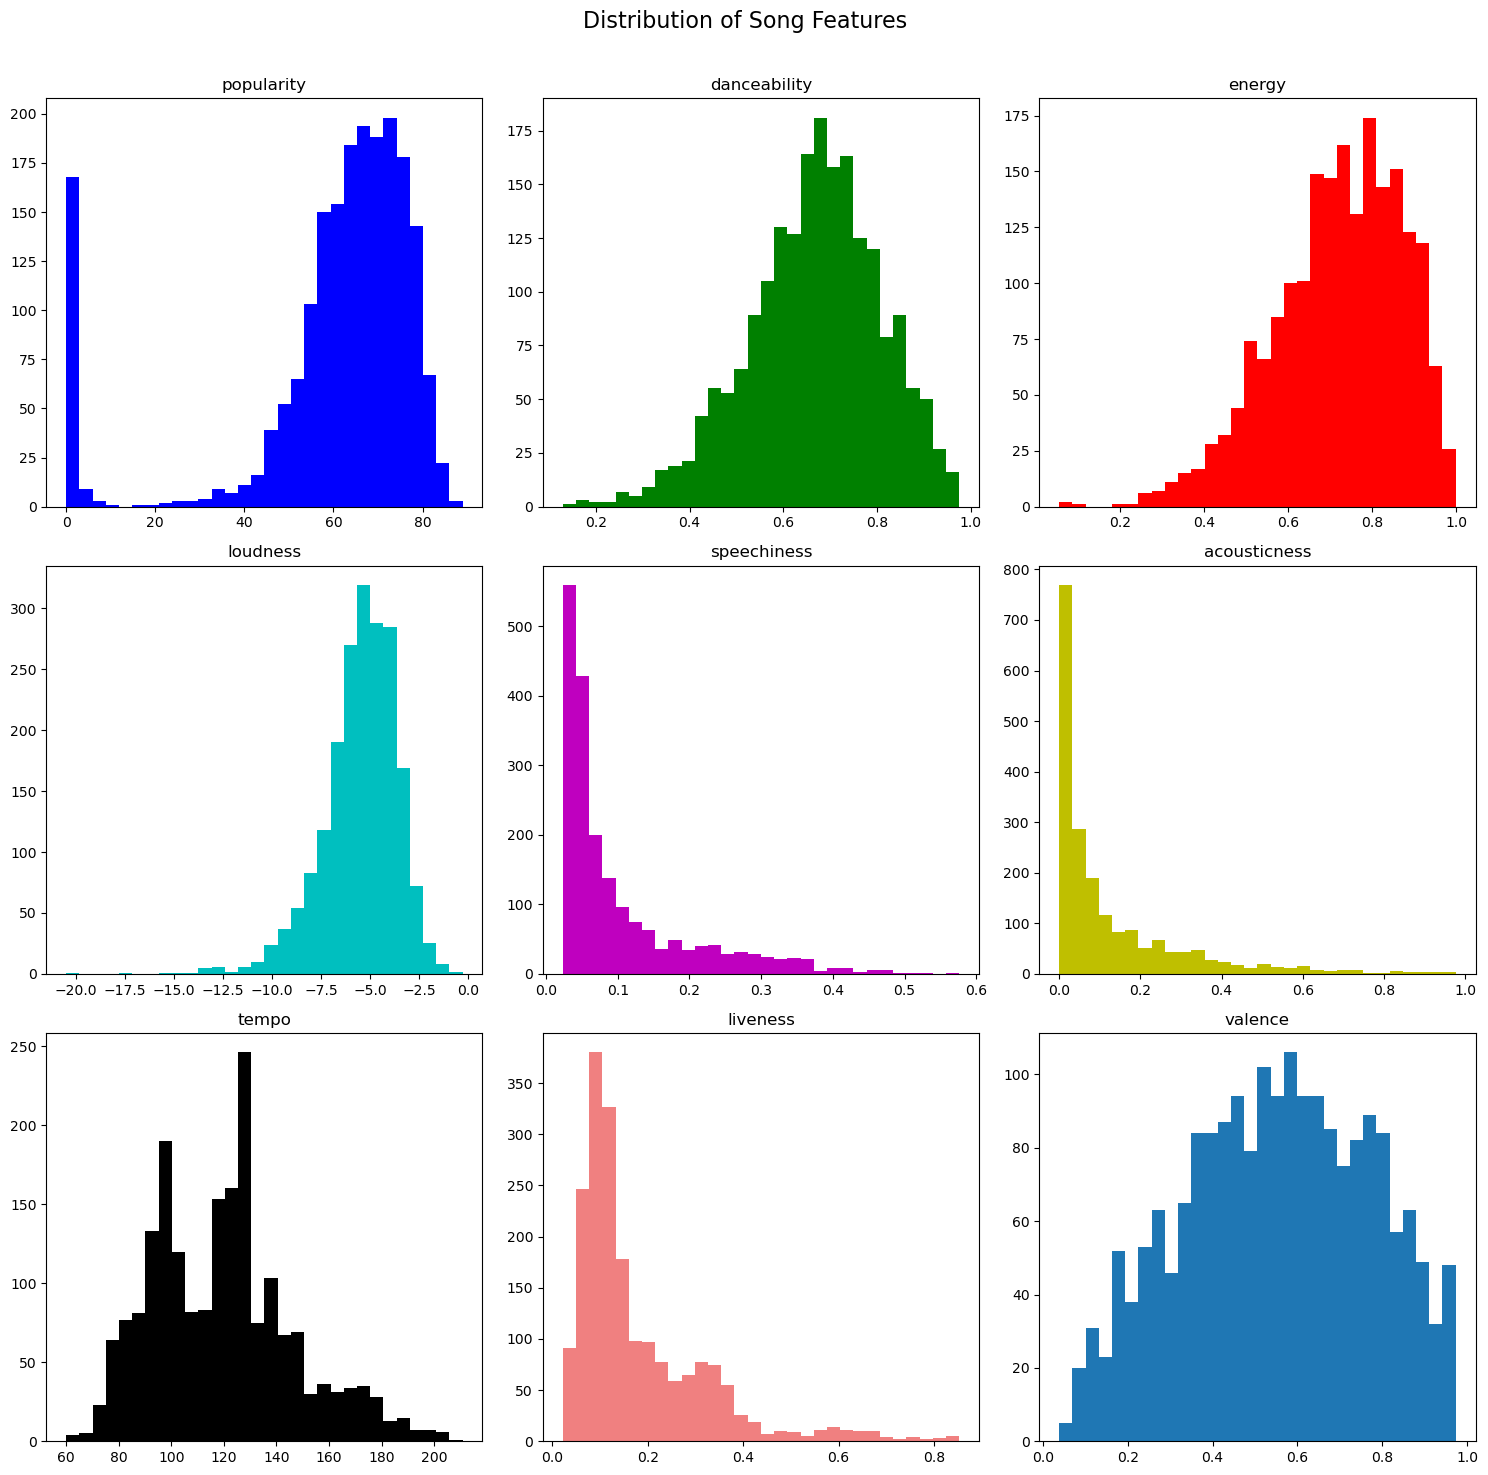

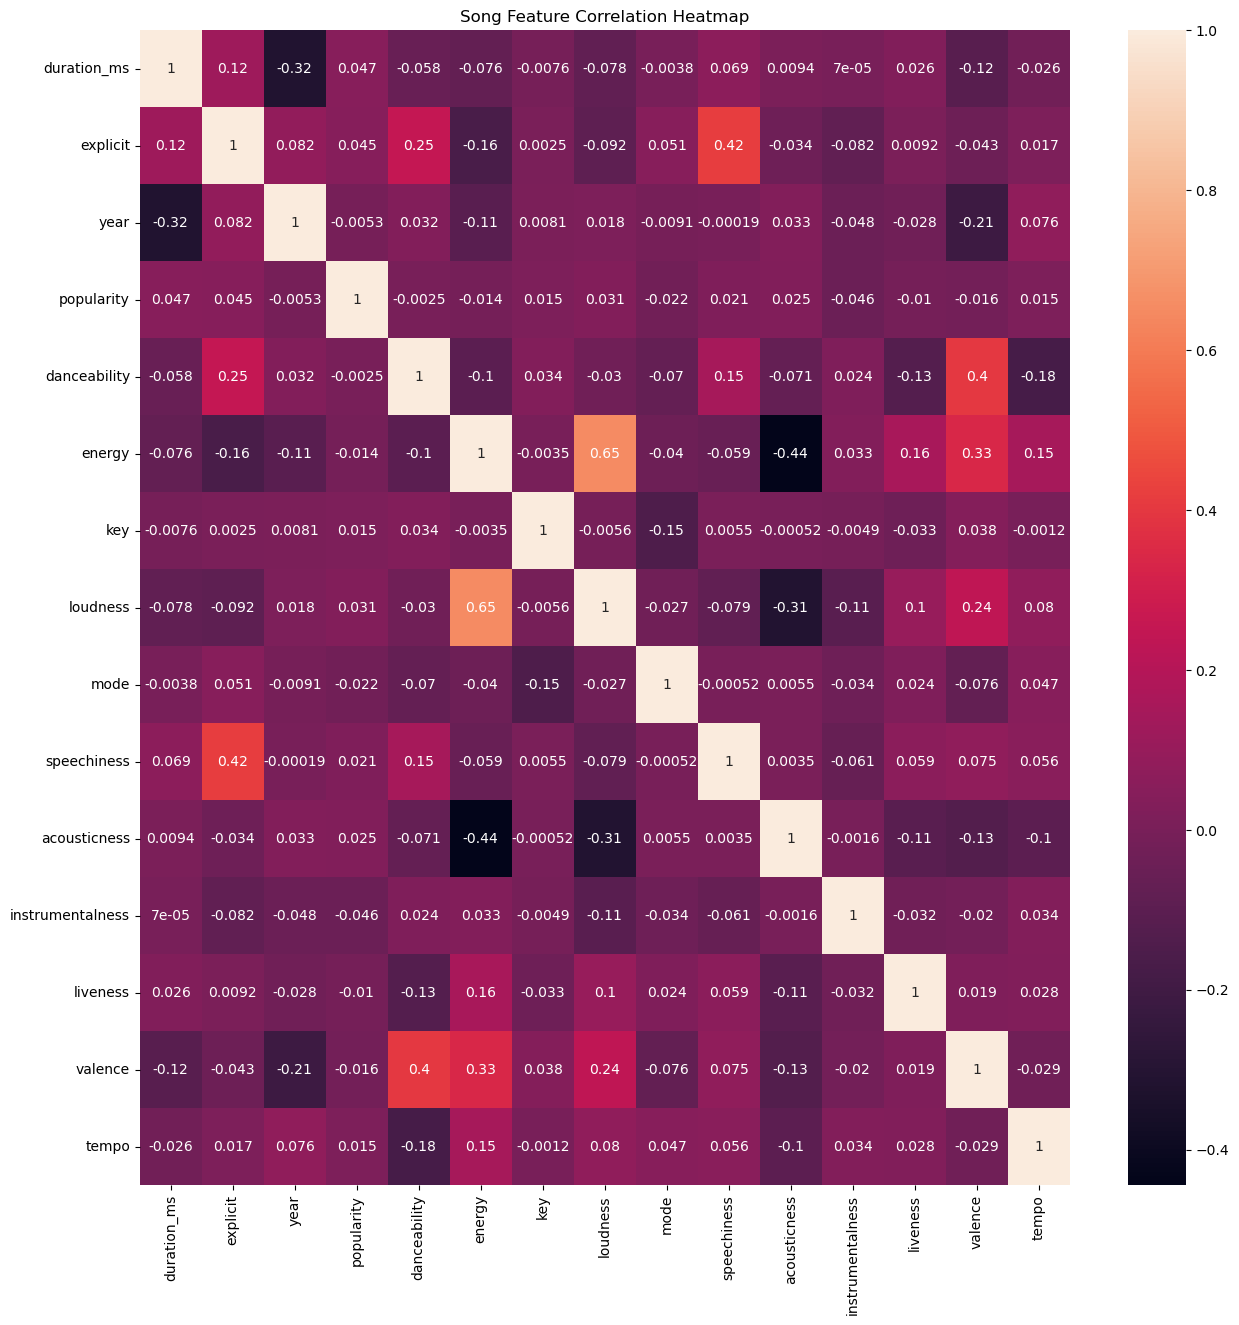

duration_ms  explicit      year  popularity  danceability  \
duration_ms          1.000000  0.122021 -0.316659    0.047032     -0.058126   
explicit             0.122021  1.000000  0.081857    0.045281      0.253391   
year                -0.316659  0.081857  1.000000   -0.005254      0.031957   
popularity           0.047032  0.045281 -0.005254    1.000000     -0.002514   
danceability        -0.058126  0.253391  0.031957   -0.002514      1.000000   
energy              -0.075504 -0.163529 -0.107856   -0.013519     -0.103340   
key                 -0.007570  0.002489  0.008088    0.015259      0.034147   
loudness            -0.078486 -0.092209  0.017890    0.030728     -0.030174   
mode                -0.003807  0.050769 -0.009135   -0.021809     -0.069726   
speechiness          0.068740  0.418052 -0.000190    0.020830      0.148249   
acousticness         0.009356 -0.033826  0.033308    0.025028     -0.071429   
instrumentalness     0.000070 -0.082020 -0.048317   -0.045873      0.023803   
liveness             0.025609  0.009164 -0.028411   -0.010212     -0.126816   
valence             -0.115022 -0.042921 -0.210931   -0.016347      0.401151   
tempo               -0.025940  0.016569  0.076019    0.014502     -0.175255   

                    energy       key  loudness      mode  speechiness  \
duration_ms      -0.075504 -0.007570 -0.078486 -0.003807     0.068740   
explicit         -0.163529  0.002489 -0.092209  0.050769     0.418052   
year             -0.107856  0.008088  0.017890 -0.009135    -0.000190   
popularity       -0.013519  0.015259  0.030728 -0.021809     0.020830   
danceability     -0.103340  0.034147 -0.030174 -0.069726     0.148249   
energy            1.000000 -0.003527  0.652265 -0.039785    -0.059297   
key              -0.003527  1.000000 -0.005552 -0.150405     0.005498   
loudness          0.652265 -0.005552  1.000000 -0.026889    -0.078762   
mode             -0.039785 -0.150405 -0.026889  1.000000    -0.000524   
speechiness      -0.059297  0.005498 -0.078762 -0.000524     1.000000   
acousticness     -0.444334 -0.000521 -0.309609  0.005502     0.003498   
instrumentalness  0.033308 -0.004933 -0.109317 -0.034490    -0.061459   
liveness          0.157277 -0.032932  0.099726  0.023512     0.058802   
valence           0.334704  0.038304  0.235296 -0.075642     0.075417   
tempo             0.149416 -0.001156  0.079951  0.047011     0.056048   

                  acousticness  instrumentalness  liveness   valence     tempo  
duration_ms           0.009356          0.000070  0.025609 -0.115022 -0.025940  
explicit             -0.033826         -0.082020  0.009164 -0.042921  0.016569  
year                  0.033308         -0.048317 -0.028411 -0.210931  0.076019  
popularity            0.025028         -0.045873 -0.010212 -0.016347  0.014502  
danceability         -0.071429          0.023803 -0.126816  0.401151 -0.175255  
energy               -0.444334          0.033308  0.157277  0.334704  0.149416  
key                  -0.000521         -0.004933 -0.032932  0.038304 -0.001156  
loudness             -0.309609         -0.109317  0.099726  0.235296  0.079951  
mode                  0.005502         -0.034490  0.023512 -0.075642  0.047011  
speechiness           0.003498         -0.061459  0.058802  0.075417  0.056048  
acousticness          1.000000         -0.001615 -0.109340 -0.131260 -0.100027  
instrumentalness     -0.001615          1.000000 -0.032420 -0.019623  0.033823  
liveness             -0.109340         -0.032420  1.000000  0.019264  0.027547  
valence              -0.131260         -0.019623  0.019264  1.000000 -0.029043  
tempo                -0.100027          0.033823  0.027547 -0.029043  1.000000

In [521]:
spotify.song_feature_distribution()
spotify.feature_heatmap()

### What makes a song popular?

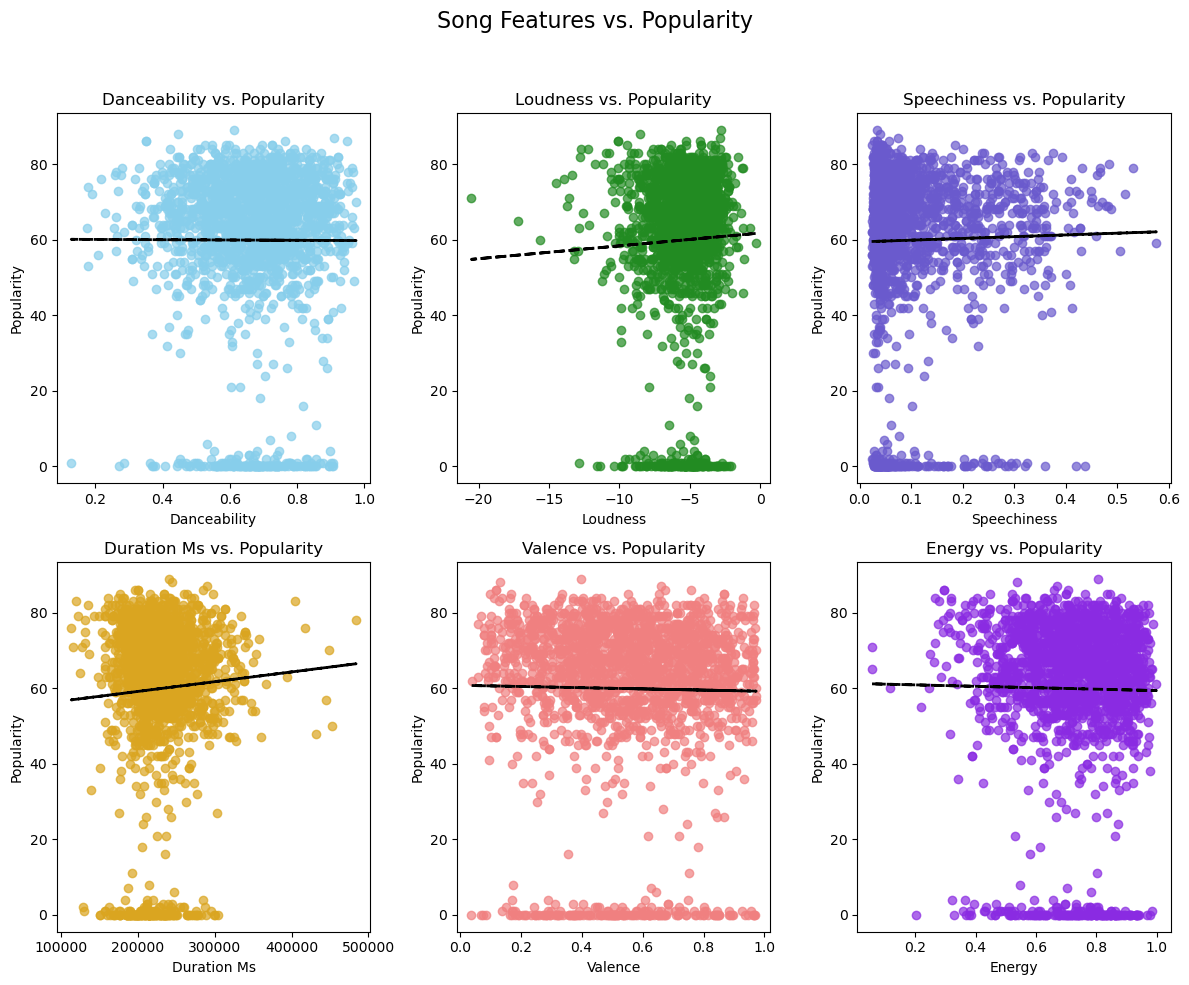

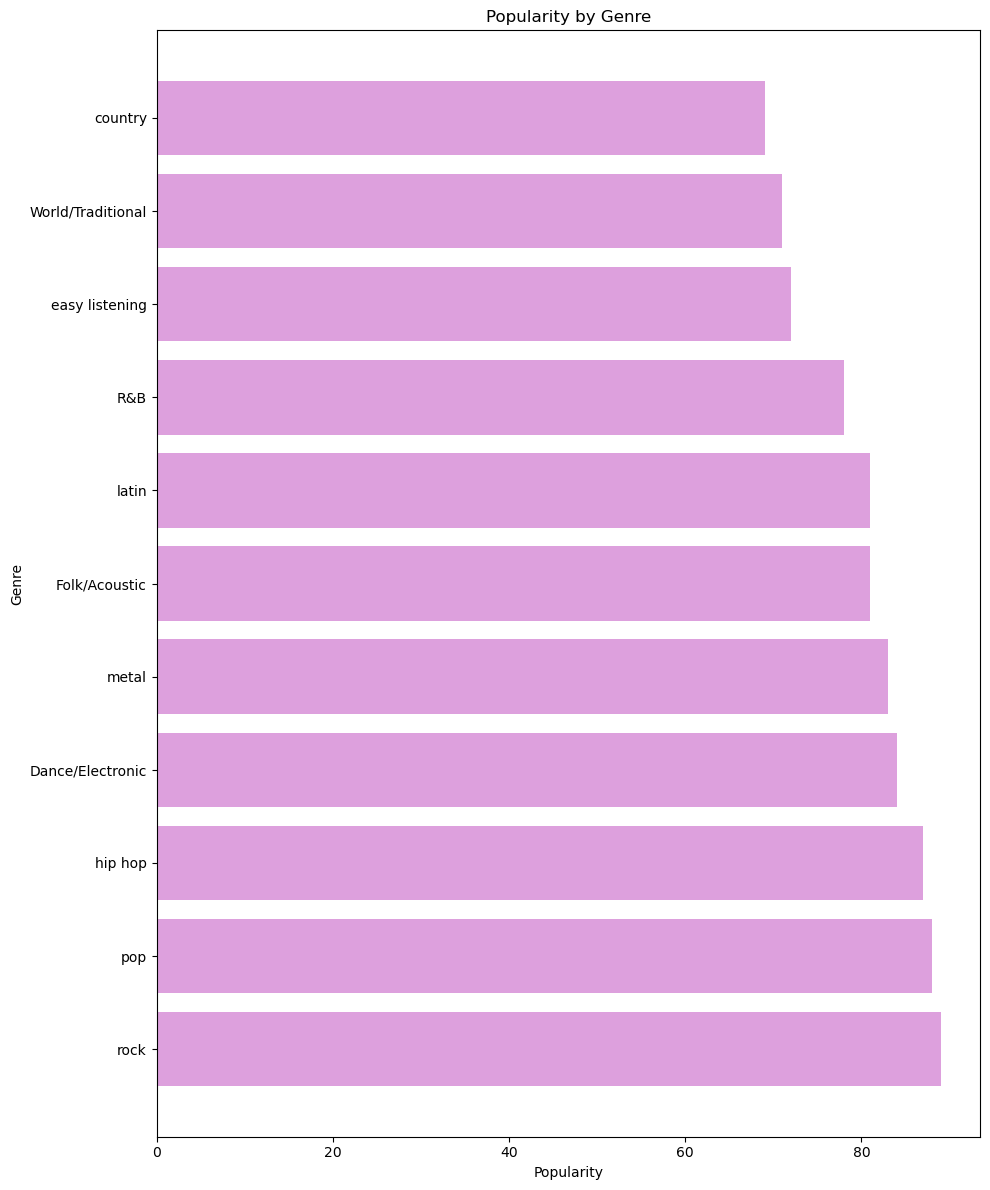

In [586]:
spotify.plot_popularity_scatterplots()
spotify.popularity_by_genre()

### Explicit vs Non-Explicit Songs

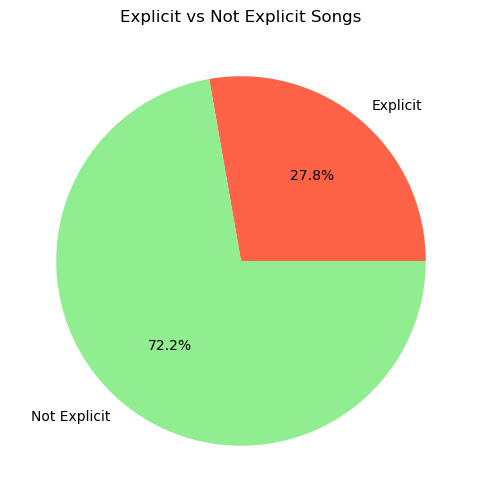

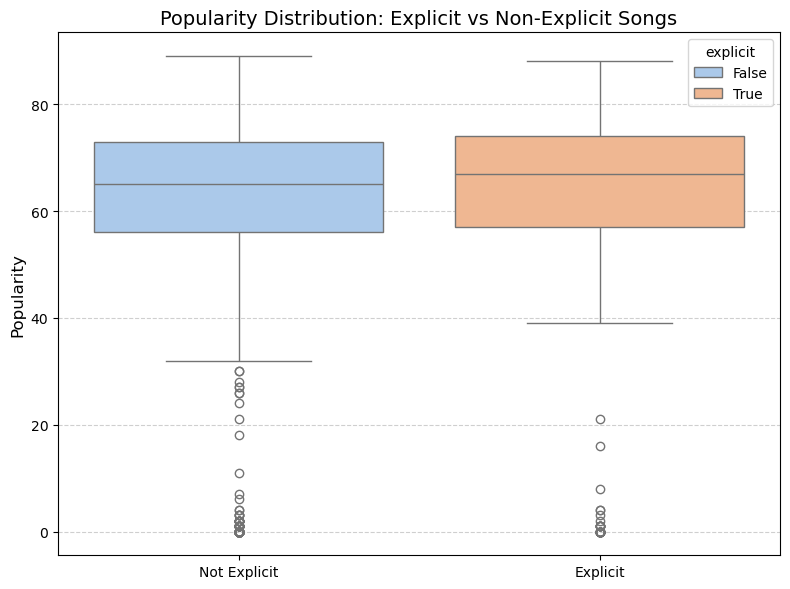

In [584]:
spotify.explicit_pie_chart()
spotify.explicit_popularity()

### Do genres differ in the sentiment and language of their song titles?

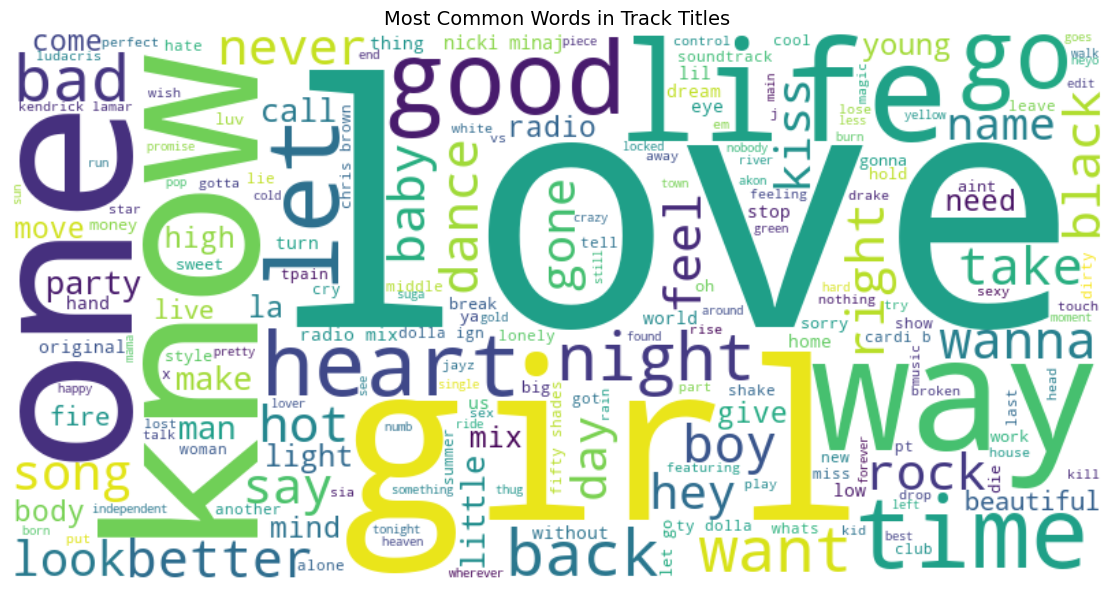

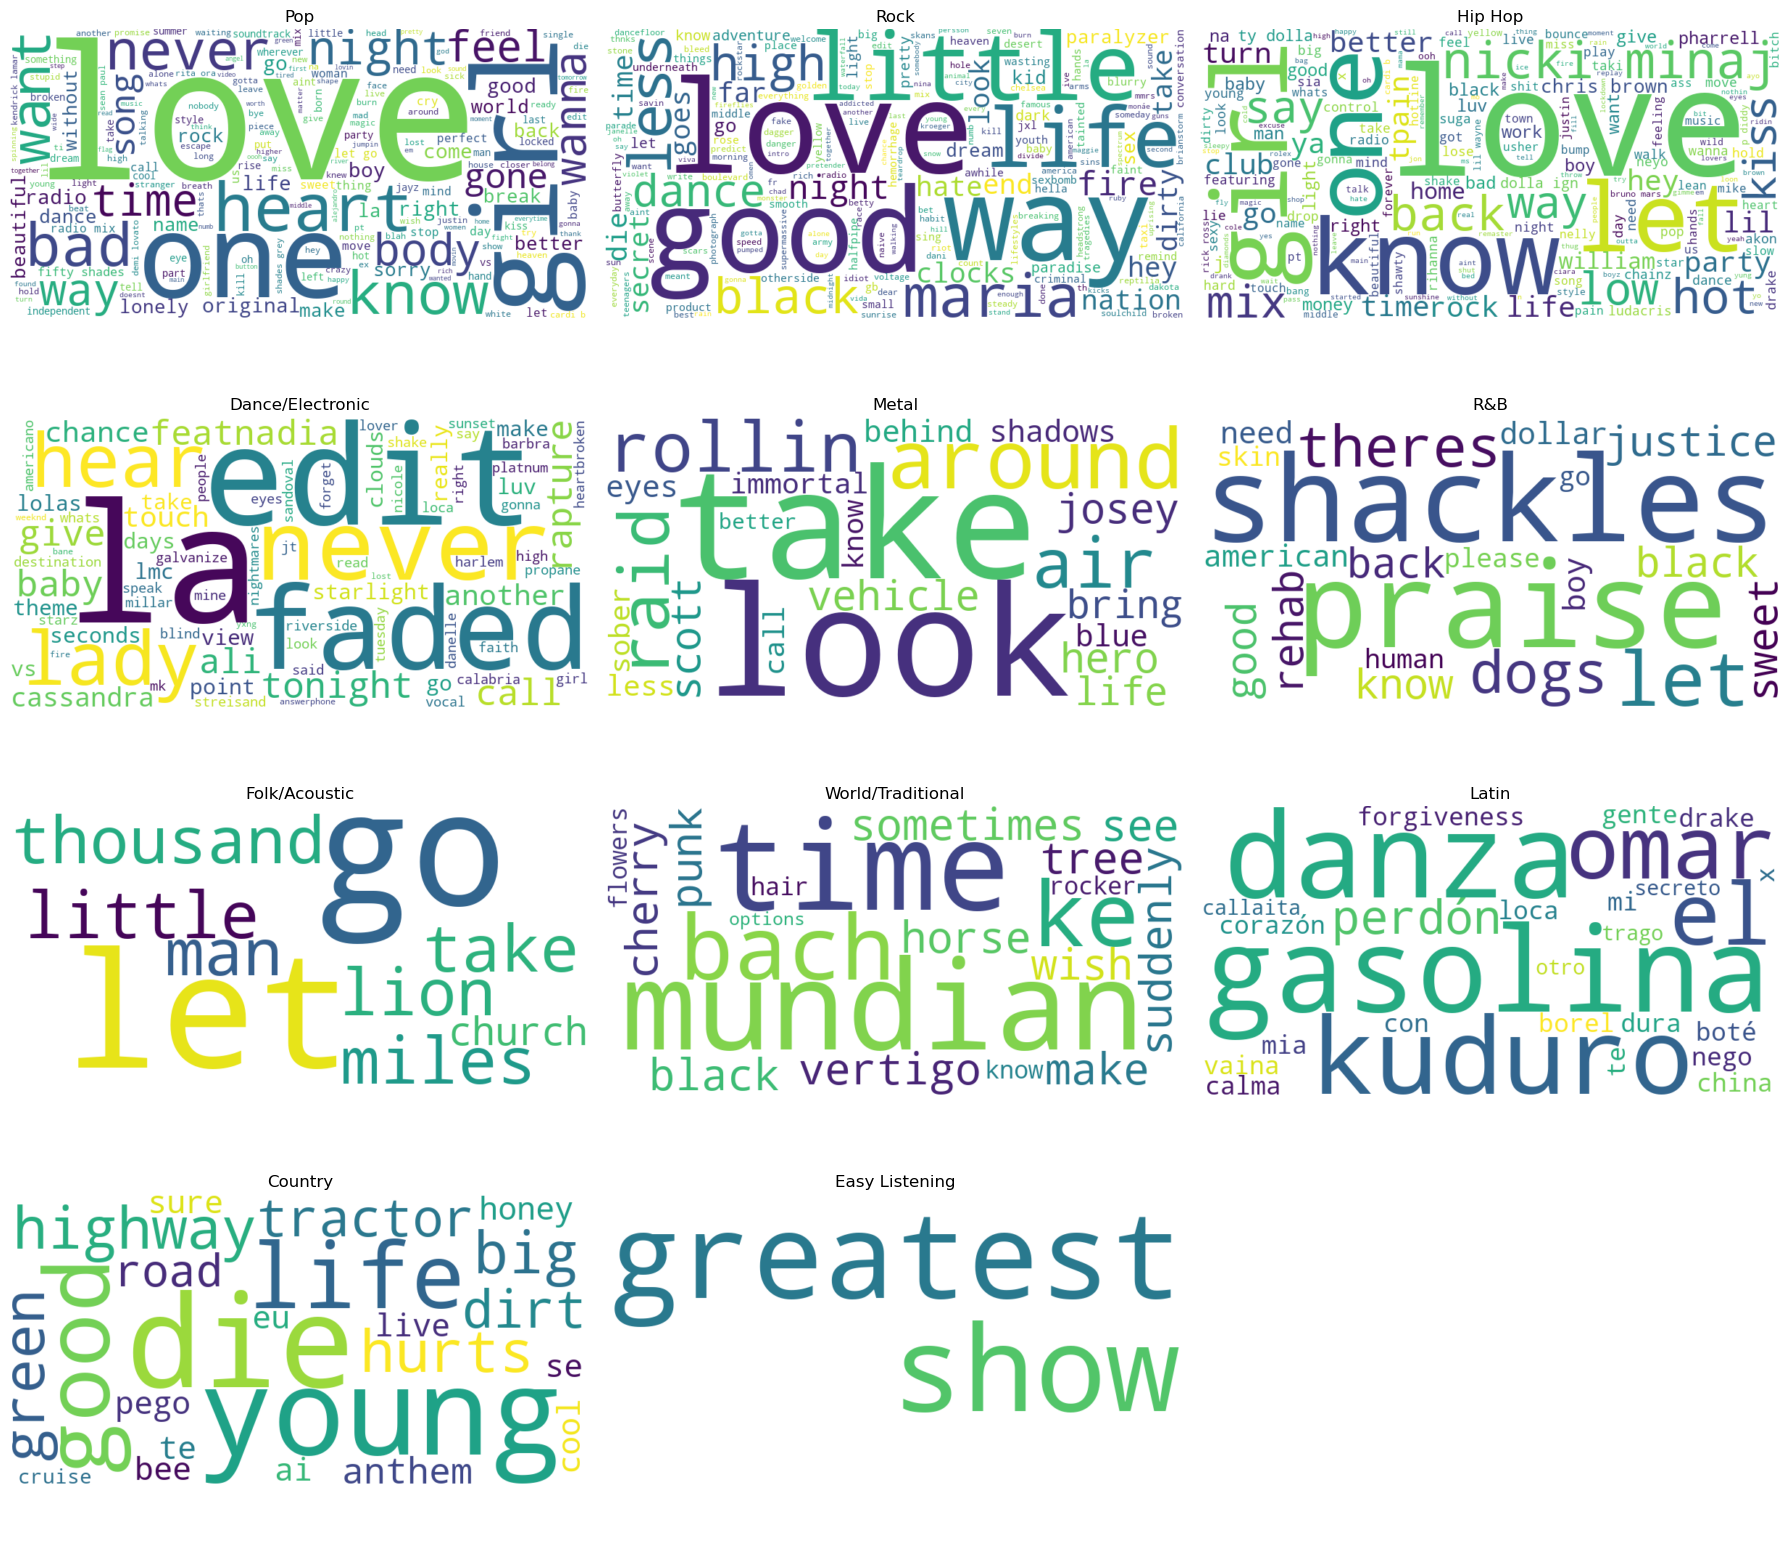

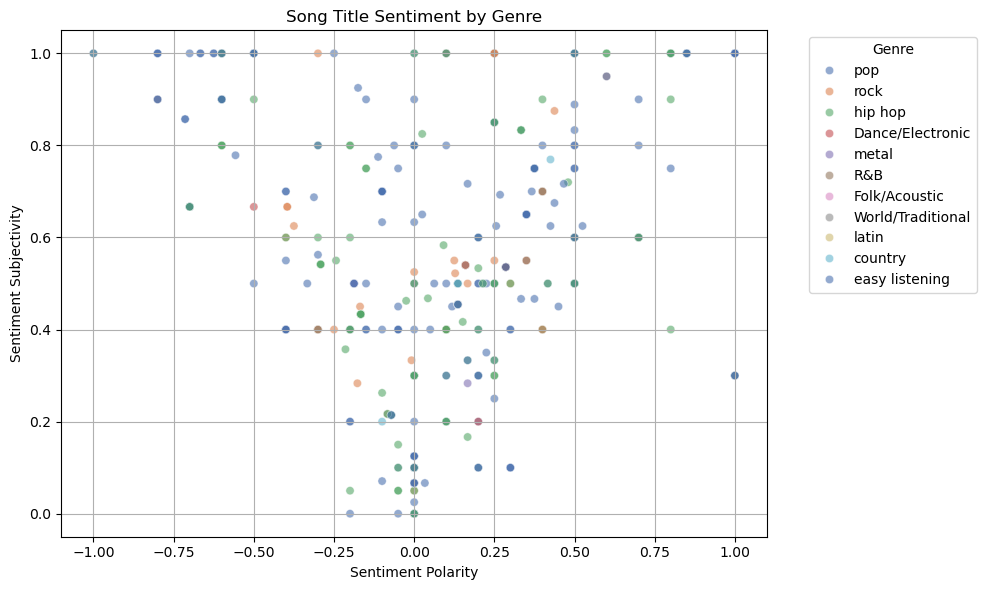

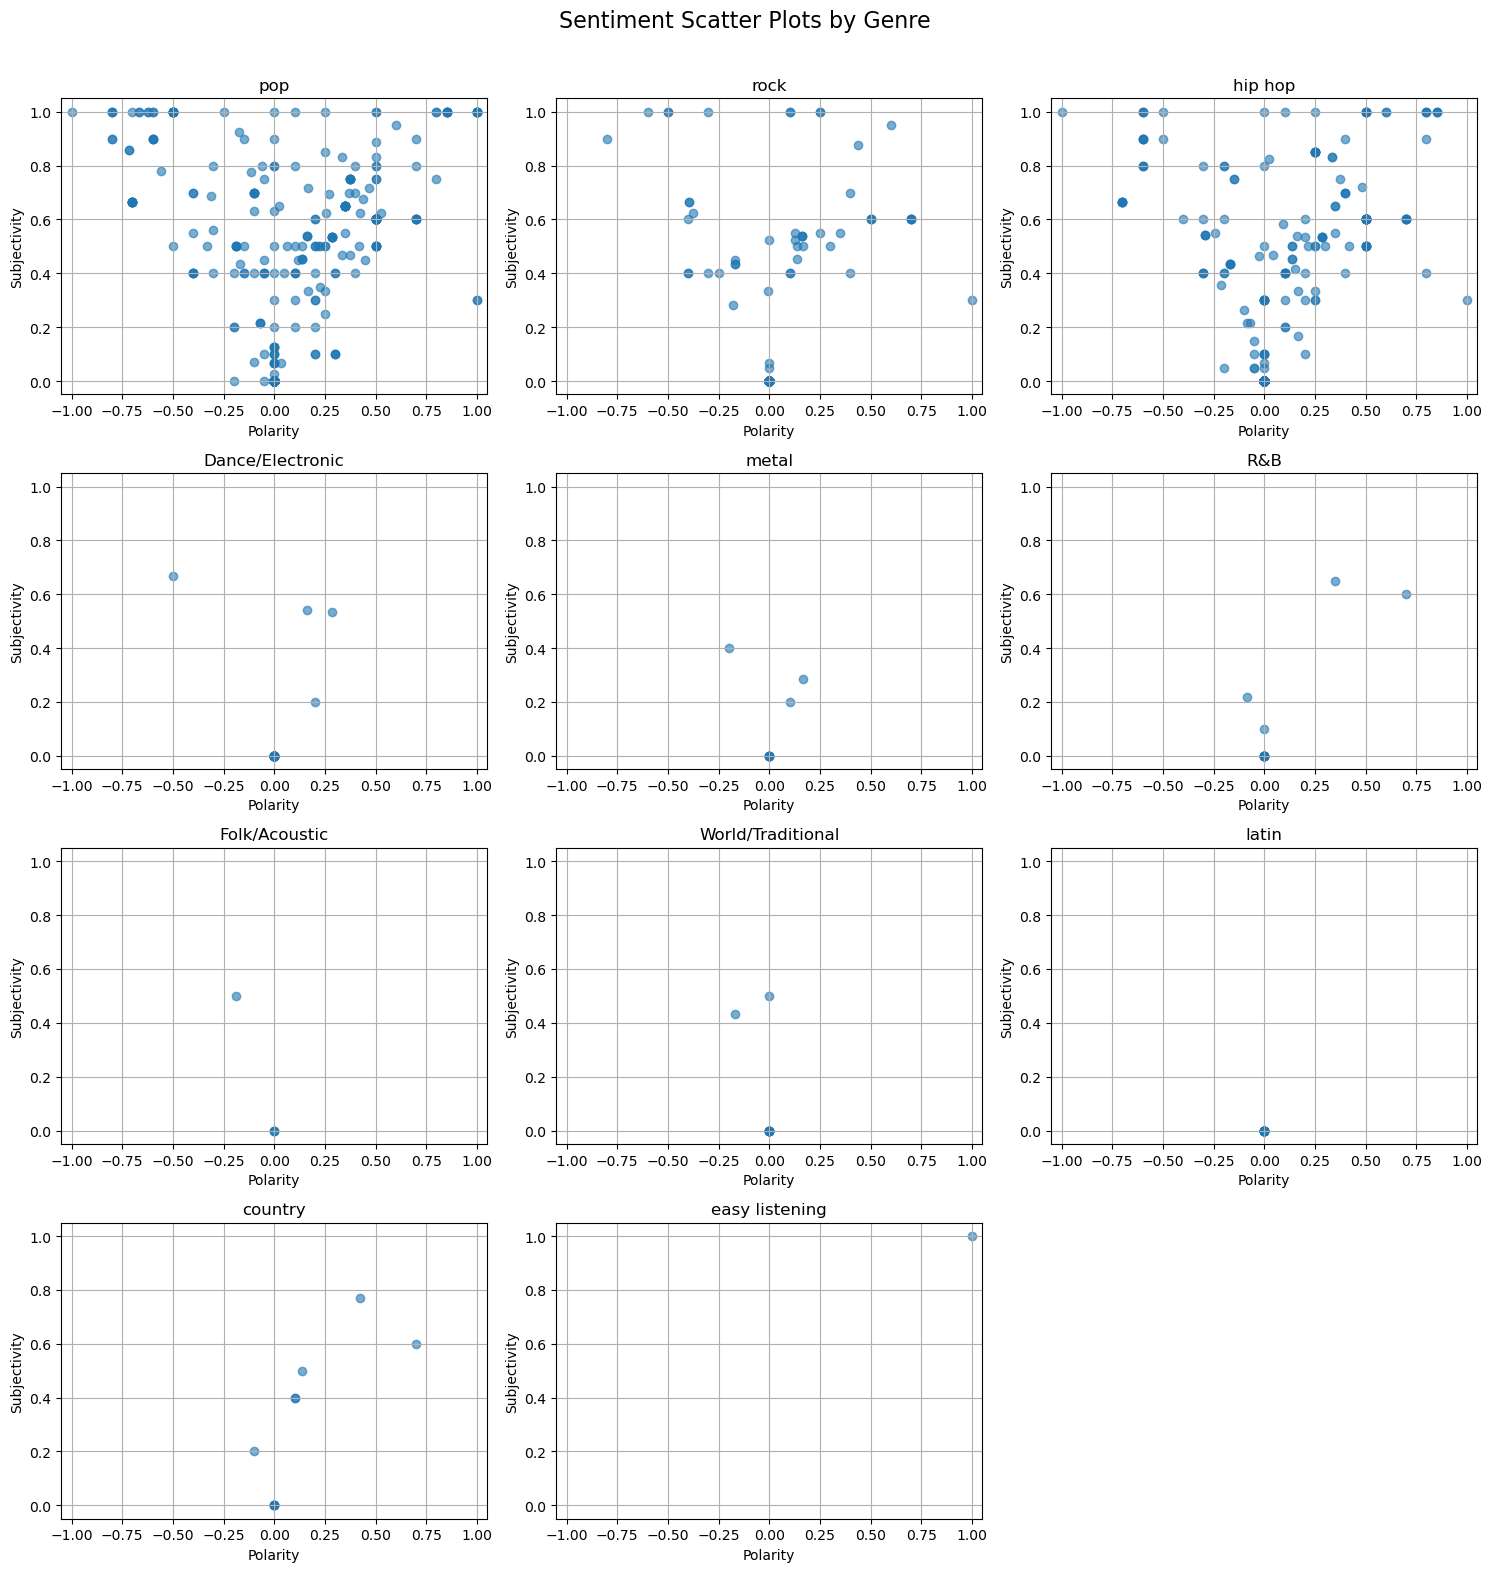

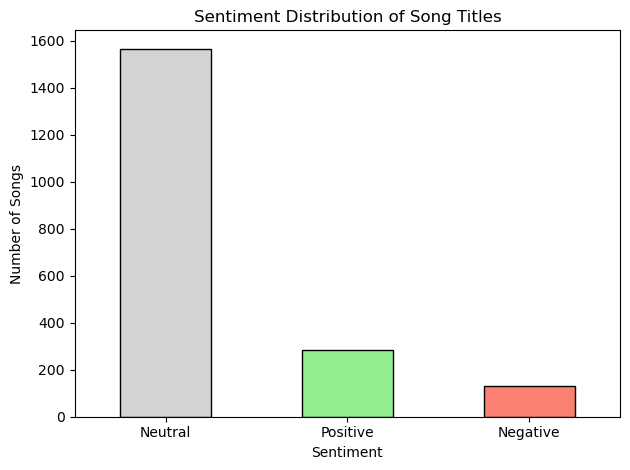

In [527]:
spotify.wordcloud_from_titles()
spotify.wordclouds_by_genre()
spotify.sentiment_analysis_by_genre()
spotify.plot_sentiment_distribution()

### Section 3: Clustering – Finding Natural Groupings in Songs

Features and targets successfully extracted.


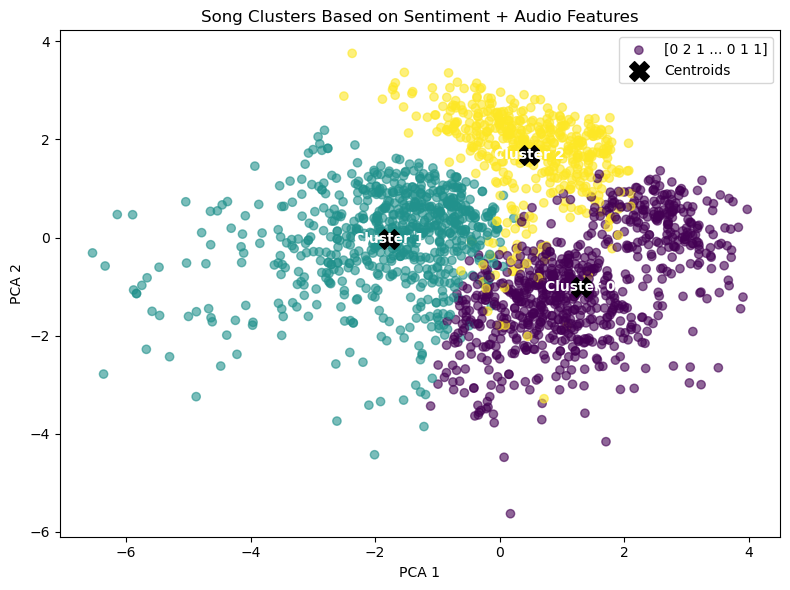


Top Features per Cluster:

Cluster 0:
  genre_popularity_mean: 59.94
  title_length: 13.36
  artist_song_count: 6.16
  word_count: 2.21
  is_danceable: 0.99

Cluster 1:
  genre_popularity_mean: 59.51
  title_length: 10.73
  artist_song_count: 6.32
  word_count: 1.74
  energy: 0.62

Cluster 2:
  genre_popularity_mean: 60.40
  title_length: 14.52
  artist_song_count: 5.68
  word_count: 2.27
  is_high_energy: 0.91


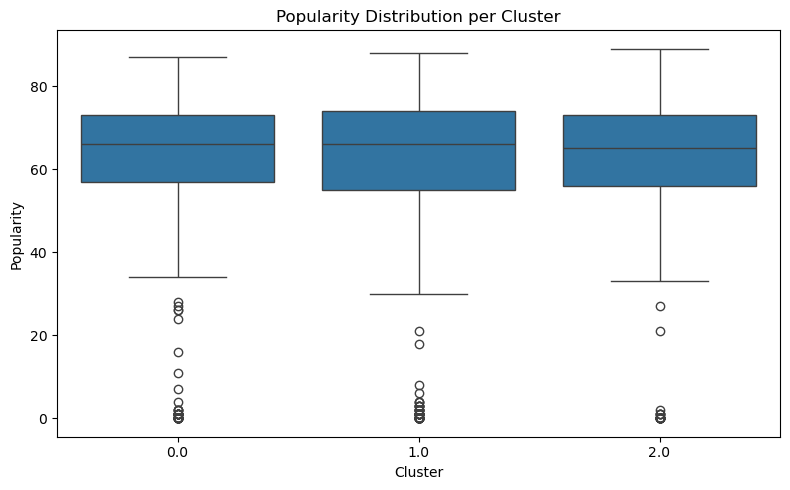

In [592]:
spotify.extract_features()
spotify.cluster_songs()
spotify.plot_cluster_popularity()

## Section 4: Linear Regression – Predicting Popularity

Linear Regression Results
----------------------------
R² Score: 0.026816613517922194
MSE: 372.3157011070301

Feature Coefficients:
title_sentiment: -0.8024
title_subjectivity: 0.4005
title_length: -0.2880
word_count: 0.3876
valence: -0.1398
energy: 6.0028
danceability: 3.7816
acousticness: 1.4531
speechiness: -0.7759
artist_song_count: 2.9534
genre_popularity_mean: 3.3505
is_high_energy: -0.2633
is_danceable: 2.0942
energy_danceability_combo: -7.0687
recent_release: 0.8141


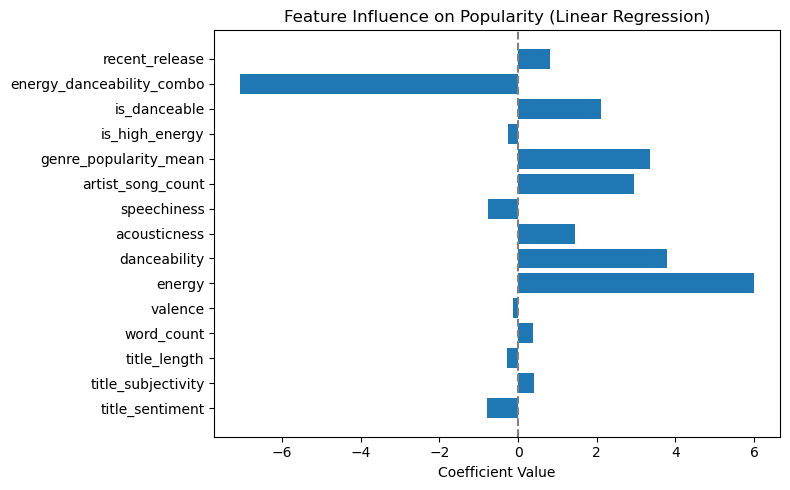

In [595]:
spotify.run_linear_regression()
spotify.plot_regression_coefficients()

## Section 5: kNN – Predicting Popularity Class

k-Nearest Neighbors Classification
-------------------------------------
Confusion Matrix:
[[216  54]
 [ 93  33]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       270
           1       0.38      0.26      0.31       126

    accuracy                           0.63       396
   macro avg       0.54      0.53      0.53       396
weighted avg       0.60      0.63      0.61       396



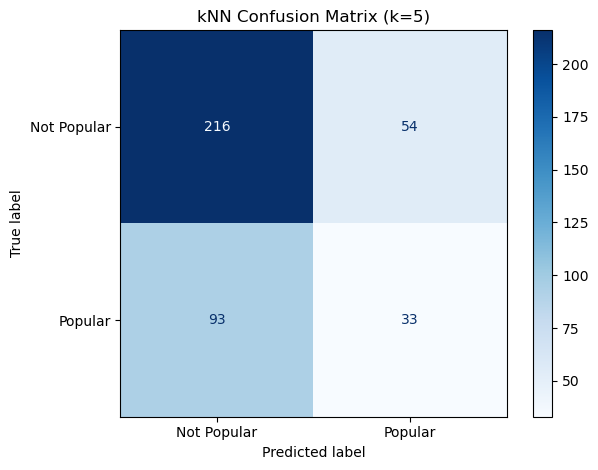

Accuracy by k-value:
k = 1: accuracy = 0.6364
k = 2: accuracy = 0.6591
k = 3: accuracy = 0.6136
k = 4: accuracy = 0.6540
k = 5: accuracy = 0.6288
k = 6: accuracy = 0.6793
k = 7: accuracy = 0.6515
k = 8: accuracy = 0.6768
k = 9: accuracy = 0.6616
k = 10: accuracy = 0.6869
k = 11: accuracy = 0.6742
k = 12: accuracy = 0.6793
k = 13: accuracy = 0.6768
k = 14: accuracy = 0.6793
k = 15: accuracy = 0.6793
k = 16: accuracy = 0.6995
k = 17: accuracy = 0.6995
k = 18: accuracy = 0.6919
k = 19: accuracy = 0.6869
k = 20: accuracy = 0.6944


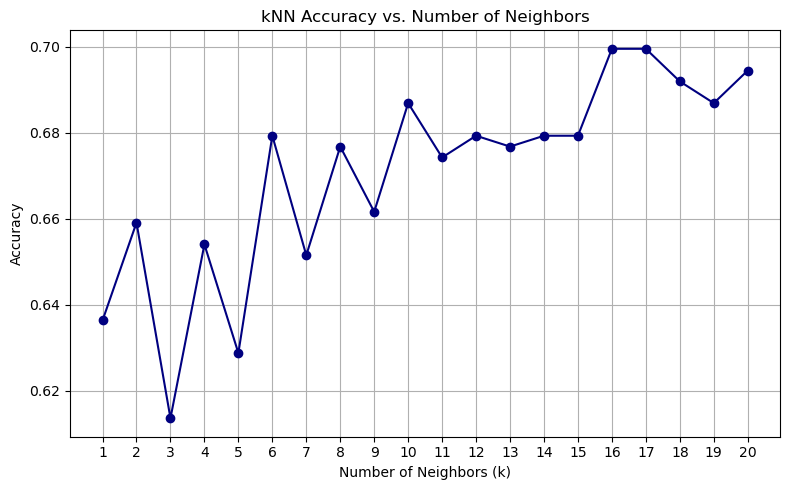

In [598]:
spotify.run_knn_classification(n_neighbors=5)
spotify.plot_knn_confusion_matrix(n_neighbors=5)
spotify.tune_knn_neighbors(range(1, 21))

## Section 6: Random Forest Classifier

Random Forest Classification
------------------------------------------
Confusion Matrix:
[[246  24]
 [ 91  35]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.91      0.81       270
           1       0.59      0.28      0.38       126

    accuracy                           0.71       396
   macro avg       0.66      0.59      0.59       396
weighted avg       0.69      0.71      0.67       396



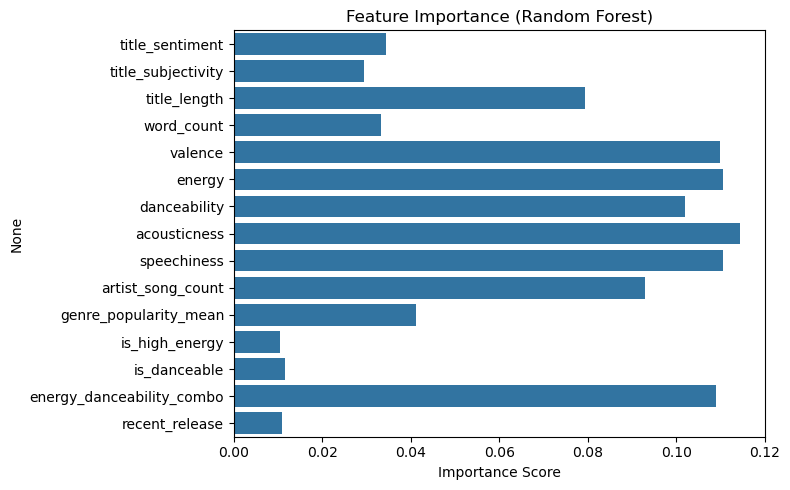

In [601]:
spotify.run_random_forest_classification()